In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import plotly.offline as pyo
import plotly.graph_objs as go

import plotly.express as px


import sys
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline


import xgboost as xgb
from xgboost import XGBClassifier

#from pylift import TransformedOutcome

from itertools import combinations
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
def load_data(data_filepath):
    df = pd.read_csv(data_filepath, parse_dates = ['became_member_on'])
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    df = df.loc[df.event == 'offer received']
    
    return df

def feature_engineering(df):
    
    
    df = df.loc[df.event == 'offer received']
    
    # income and gender null values were less than 
    df = df.dropna(subset=['income', 'gender'])
    
    df['target_class'] = 0 # Default set to Control Non-Responders where both treatment and outcome are 0.
    df.loc[(df.treatment == 0) & (df.outcome ==1),'target_class'] = 1 # Control Responders
    df.loc[(df.treatment == 1) & (df.outcome  ==0),'target_class'] = 2 # treatment Non-Responders
    df.loc[(df.treatment == 1) & (df.outcome  ==1),'target_class'] = 3 # treatment Responders
    
    # drop non-relevant features for model building purposes        
    df = df.drop(columns=['id','event', 'time', 'became_member_on', 'amount', 'offer_id', 'reward', 'max_time' ], axis=1)
    
    # subset categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
  
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

    # sepereate dataframe into features and target variable
    X = df.drop(columns=['treatment', 'outcome','target_class'], axis=1)
    y = df.target_class

    return df, X, y

In [3]:
df = load_data('dataframe.csv')

clean_df, X, y= feature_engineering(df)

clean_df.head()

,age,income,days_as_member,difficulty,duration,web,email,mobile,social,outcome,treatment,target_class,gender_M,gender_O,offer_type_discount,offer_type_informational
0,75,100000.0,923,5.0,7.0,1,1,1,0,0.0,1.0,2,0,0,0,0
5,75,100000.0,923,0.0,3.0,0,1,1,1,0.0,0.0,0,0,0,0,1
10,75,100000.0,923,10.0,7.0,0,1,1,1,0.0,1.0,2,0,0,0,0
12,75,100000.0,923,5.0,5.0,1,1,1,1,0.0,0.0,0,0,0,0,0
29,68,70000.0,571,10.0,7.0,1,1,1,0,0.0,0.0,0,1,0,1,0


In [4]:
np.sum(df.isnull()/ df.shape[0])

event               0.000000
id                  0.000000
time                0.000000
age                 0.000000
became_member_on    0.000000
gender              0.128164
income              0.128164
amount              1.000000
offer_id            0.000000
reward              1.000000
days_as_member      0.000000
difficulty          0.000000
duration            0.000000
offer_type          0.000000
web                 0.000000
email               0.000000
mobile              0.000000
social              0.000000
max_time            0.000000
outcome             0.000000
treatment           0.000000
dtype: float64

In [5]:
# rows where income and gender values are null will be dropped since it only represent ~13%.
df = df.dropna(subset=['income', 'gender'])

In [6]:
pd.crosstab(df['treatment'], df['outcome'], margins=True)

outcome,0.0,1.0,All
treatment,,,
0.0,46912,4519,51431
1.0,12207,2863,15070
All,59119,7382,66501


On an event level of analysis, there are..

46,912 Control Non-Responders

4,519 Control Responders

12,207 Treatment Non-Responders

2,863 Treatment Responders

The model we will be building next will be a nonbinary classification that will predict the class based on these four segments.

A 'target_class' feature will be created.

In [7]:
df['target_class'] = 0 # Default set to Control Non-Responders where both treatment and outcome are 0.
df.loc[(df.treatment == 0) & (df.outcome ==1),'target_class'] = 1 # Control Responders
df.loc[(df.treatment == 1) & (df.outcome  ==0),'target_class'] = 2 # treatment Non-Responders
df.loc[(df.treatment == 1) & (df.outcome  ==1),'target_class'] = 3 # treatment Responders

In [8]:
class_dict = {0:'Control Non-Responder', 1: 'Control Responder', 2: 'Treatment Non-Responder', 3: 'Treatment Responder'}

In [9]:
classes = ['Control Non-Responder', 'Control Responder', 'Treatment Non-Responder', 'Treatment Responder']

The value counts for the new 'target_class' match the values above.

In [10]:
df.target_class.value_counts()

0    46912
2    12207
1     4519
3     2863
Name: target_class, dtype: int64

Remaining cleaning of the data will be done to then have it ready for model building.

In [28]:
def clean_data(df):
    # drop non-relevant features for model building purposes        
    df = df.drop(columns=['id','event', 'time', 'became_member_on', 'amount', 'offer_id', 'reward', 'max_time' ], axis=1)
    
    # subset categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
  
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df.drop(columns=['treatment', 'outcome','target_class'], axis=1)
    y = df.target_class
    
    return df, X, y

clean_df, X, y = clean_data(df)

clean_df.head()

,age,income,days_as_member,difficulty,duration,web,email,mobile,social,outcome,treatment,target_class,gender_M,gender_O,offer_type_discount,offer_type_informational
0,75,100000.0,923,5.0,7.0,1,1,1,0,0.0,1.0,2,0,0,0,0
5,75,100000.0,923,0.0,3.0,0,1,1,1,0.0,0.0,0,0,0,0,1
10,75,100000.0,923,10.0,7.0,0,1,1,1,0.0,1.0,2,0,0,0,0
12,75,100000.0,923,5.0,5.0,1,1,1,1,0.0,0.0,0,0,0,0,0
29,68,70000.0,571,10.0,7.0,1,1,1,0,0.0,0.0,0,1,0,1,0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

In [12]:
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ConfusionMatrix

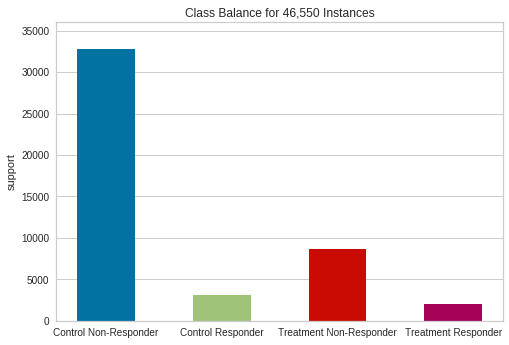

In [37]:
def class_balance(y):
    
    y = pd.Series(y).map(class_dict).values
    visualizer = ClassBalance(labels=classes)

    visualizer.fit(y)
    viz_show = visualizer.show()
    
    return viz_show

class_balance_viz = class_balance(y_train)

There is a class imbalance which could have negative repurcussions for training the classification model. 

An alternative training dataframe will be created that utilizes an upsampling method  to reduce the imbalance. 

In [34]:
def upsample(df, column, majority_value, minority_value):
    
    # Up-sample Minority Class approach from Elite Data Science 
    # https://elitedatascience.com/imbalanced-classes


    # Seperate majority and minority classes
    df_majority = df[df[column] == majority_value]
    df_minority = df[df[column] == minority_value]
    
    majority_n_samples = df[column].value_counts()[majority_value]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority,
                                replace=True,
                                n_samples=majority_n_samples,
                                random_state=42)

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    return df_upsampled

def upsample_train(train_df):
    train_df_upsample = upsample(train_df, 'treatment', 0, 1)
    X_train = train_df_upsample.drop(columns=['treatment', 'outcome','target_class'], axis=1)
    y_train = train_df_upsample.target_class
    
    
    
    return X_train, y_train



X_train_upsampled, y_train_upsampled = upsample_train(train_df)

In [35]:
clf = RandomForestClassifier()

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



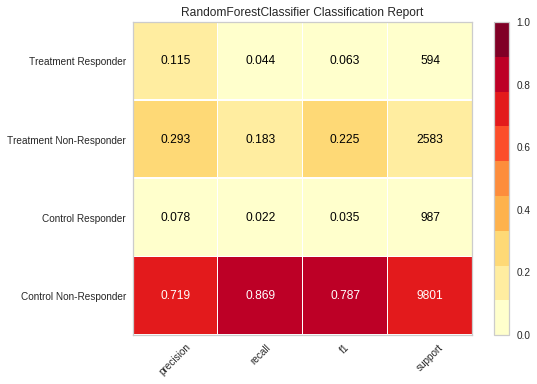

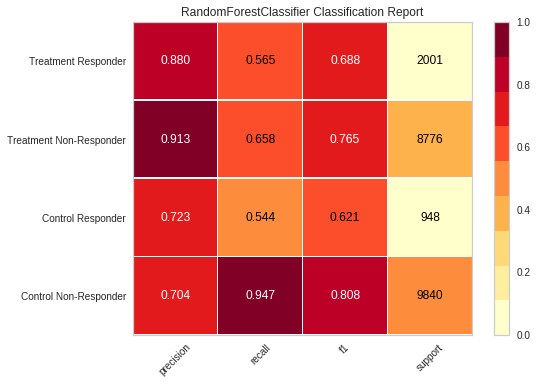

In [36]:
def classification_report(X, y, model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    
    
    visualizer = ClassificationReport(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
    viz_show = visualizer.show()
    
    
    
    return viz_show

classification_report_ = classification_report(X_train, y_train, clf)
classification_report_upsampled = classification_report(X_train_upsampled, y_train_upsampled, clf)

We can see in the above classification reports that the top report contains many more cells where the precision and recall is closer to 0% for the minority class. This is due to the classifier being biased toward classifiying most of all as 'Control Non-Responder', the majority class.

The bottom classification report has a much more healthy balance in terms of precision and recall across the classes and crucially for the Treatment Responder segment. 

Our business goal is to prioritize reaching out to The Treatment Responder segment so being able to increase the precision and recall for that class specifically is critical.

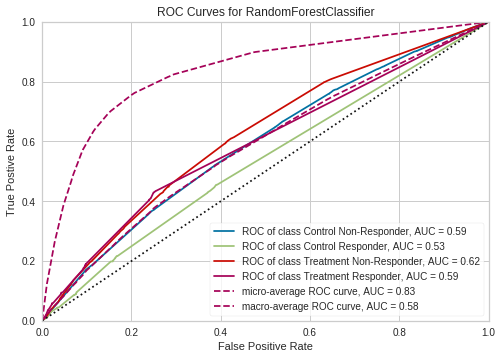

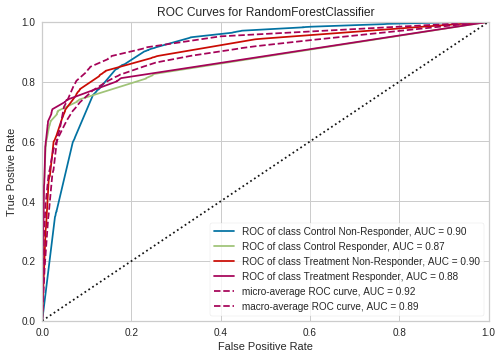

In [39]:
def rocauc(X, y, model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    
    
    
    visualizer = ROCAUC(model, classes=classes, support=True)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
    viz_show = visualizer.show()
    
    
    
    return viz_show

rocauc_ = rocauc(X_train, y_train, clf)
rocauc_upsampled = rocauc(X_train_upsampled, y_train_upsampled, clf)

The ROC Curves above also illustrate how the upsampled data performs better as the climb in the True Positive Rate, measured on the y axis, happens at a much greater rate than the unsampled data.

Once again, the curve we are particularly mindful of is the burgundy ROC Curve, which measures the Treatment Responders segment. The Area Under the Curve ("AUC") for the upsampled data is 0.88 which performs much better than the unsampled data with an AUC of 0.59.

# Implementation

Due to the performance advantages of the upsampled data, the build_model.py file will include the upsample and upsampl_train functions as preprocessing steps.